yt_xarray : [INFO ] 2024-03-12 11:37:27,910:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:28,095:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:28,136:  Decomposed into 101 grids after 51 iterations.
yt : [INFO     ] 2024-03-12 11:37:28,171 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:28,172 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:28,172 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:28,173 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:28,173 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:28,335 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:28,336 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:28,337 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:28,33


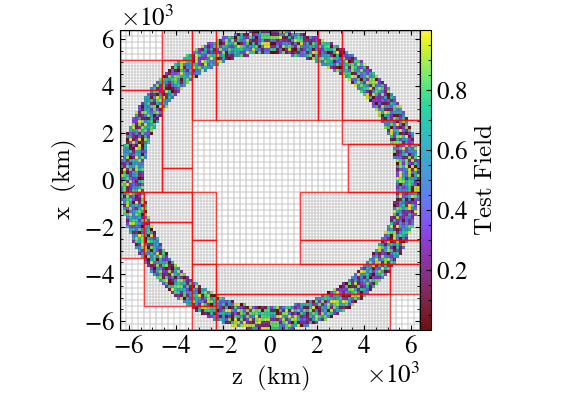

yt_xarray : [INFO ] 2024-03-12 11:37:28,821:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:29,010:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:29,073:  Decomposed into 146 grids after 101 iterations.
yt : [INFO     ] 2024-03-12 11:37:29,109 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:29,110 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:29,111 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:29,111 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:29,112 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:29,273 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:29,274 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:29,276 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:29,2


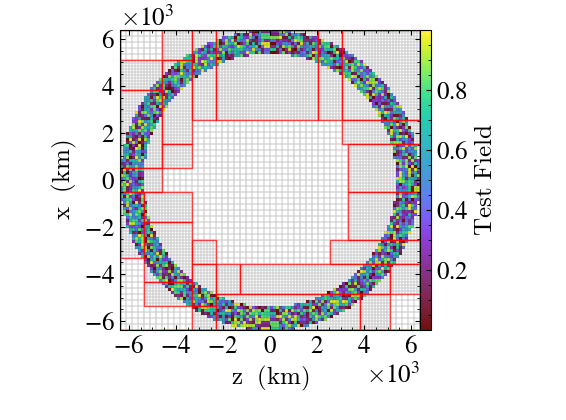

yt_xarray : [INFO ] 2024-03-12 11:37:29,764:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:29,957:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:30,069:  Decomposed into 246 grids after 201 iterations.
yt : [INFO     ] 2024-03-12 11:37:30,109 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:30,109 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:30,110 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:30,110 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:30,111 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:30,299 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:30,299 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:30,301 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:30,3


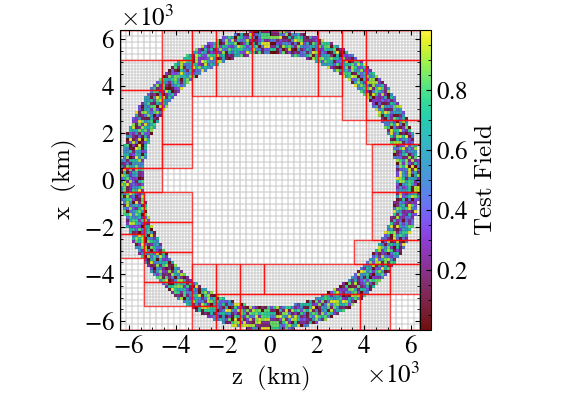

yt_xarray : [INFO ] 2024-03-12 11:37:30,773:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:30,981:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:31,144:  Decomposed into 369 grids after 401 iterations.
yt : [INFO     ] 2024-03-12 11:37:31,185 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:31,185 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:31,186 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:31,186 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:31,187 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:31,539 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:31,540 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:31,542 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:31,5


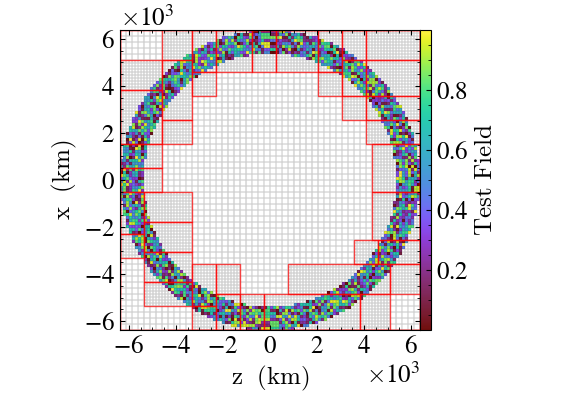

yt_xarray : [INFO ] 2024-03-12 11:37:32,021:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:32,222:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:32,421:  Decomposed into 433 grids after 601 iterations.
yt : [INFO     ] 2024-03-12 11:37:32,467 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:32,468 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:32,468 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:32,469 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:32,469 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:32,682 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:32,682 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:32,684 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:32,6


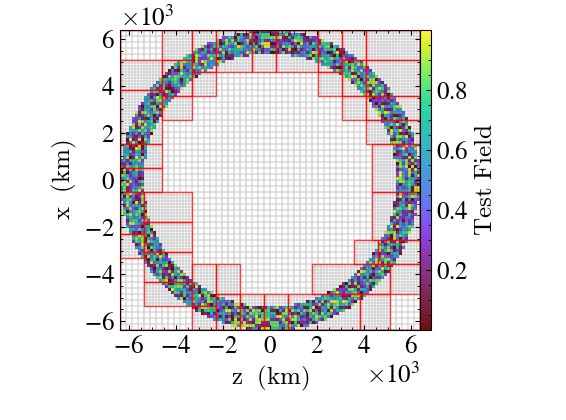

yt_xarray : [INFO ] 2024-03-12 11:37:33,162:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:33,354:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:33,573:  Decomposed into 472 grids after 801 iterations.
yt : [INFO     ] 2024-03-12 11:37:33,620 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:33,621 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:33,621 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:33,622 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:33,622 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:33,976 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:33,977 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:33,979 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:33,9


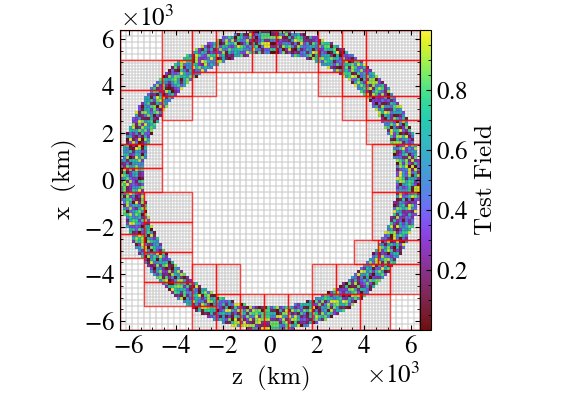

yt_xarray : [INFO ] 2024-03-12 11:37:34,455:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 11:37:34,638:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 11:37:34,850:  Decomposed into 472 grids after 828 iterations.
yt : [INFO     ] 2024-03-12 11:37:34,894 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 11:37:34,895 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2024-03-12 11:37:34,895 Parameters: domain_left_edge          = [-6356. -6366. -6372.]
yt : [INFO     ] 2024-03-12 11:37:34,896 Parameters: domain_right_edge         = [6369. 6366. 6372.]
yt : [INFO     ] 2024-03-12 11:37:34,896 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 11:37:35,100 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:35,101 ylim = -6356.000000 6369.000000
yt : [INFO     ] 2024-03-12 11:37:35,102 xlim = -6372.000000 6372.000000
yt : [INFO     ] 2024-03-12 11:37:35,1


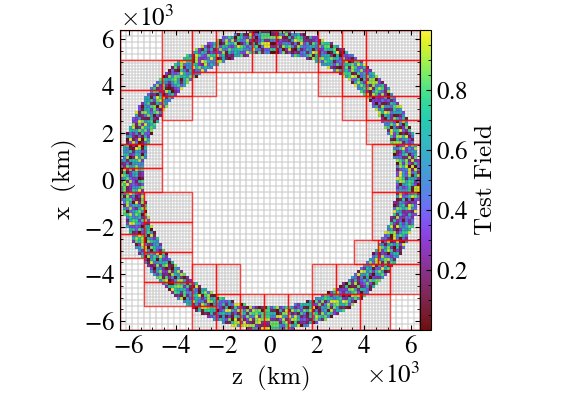

In [7]:
from yt_xarray.utilities._utilities import (
    construct_minimal_ds,
)
from yt_xarray.transformations import build_interpolated_cartesian_ds
import yt 

dim_names = ("longitude", "latitude", "depth")


ds = construct_minimal_ds(    
    min_x=0, 
    max_x=360,
    x_stretched=False,
    x_name=dim_names[0],
    n_x=50,
    min_y=-90., 
    max_y=90,
    y_stretched=False,
    y_name=dim_names[1],
    n_y=60,    
    z_stretched=False,
    z_name=dim_names[2],
    n_z=80,
    min_z=0.0,
    max_z=1000.0, 
)

fields = list(ds.data_vars)

for max_iters in (50, 100, 200, 400, 600, 800, 1000):
    ds_yt = build_interpolated_cartesian_ds(
        ds, 
        ('test_field',),
        'depth', 
        grid_resolution = (50, 50, 50),      
        refine_grid=True,         
        refine_max_iters=max_iters,
    )
    
    slc = yt.SlicePlot(ds_yt, 'y', ('test_field'), window_size=(3,3))
    slc.set_log('test_field', False)
    slc.annotate_cell_edges(alpha=0.2)    
    slc.annotate_grids(edgecolors=(1.,0,0,0))
    slc.show()

yt_xarray : [INFO ] 2024-03-12 12:26:42,745:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-03-12 12:26:42,925:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-03-12 12:26:42,941:  Decomposed into 43 grids after 65 iterations.
yt : [INFO     ] 2024-03-12 12:26:42,975 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-12 12:26:42,976 Parameters: domain_dimensions         = [20 20 20]
yt : [INFO     ] 2024-03-12 12:26:42,976 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-03-12 12:26:42,977 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-03-12 12:26:42,977 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-12 12:26:43,172 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 12:26:43,172 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 12:26:43,174 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 12:26:43


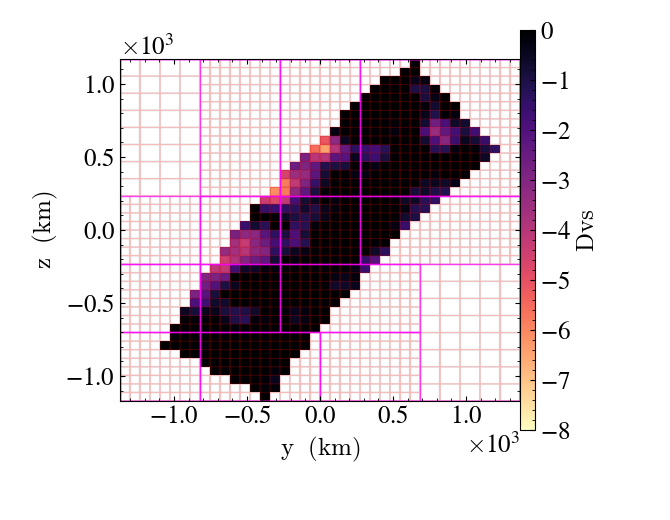

In [5]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray import transformations

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
grid_resolution = (20, 20, 20)
ds_yt = transformations.build_interpolated_cartesian_ds(
    ds,
    [
        "dvs",
    ],
    "depth",
    grid_resolution = grid_resolution, 
    refine_grid=True,
    refine_max_iters=2000,
    refine_min_grid_size=2,
)


slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

yt : [INFO     ] 2024-03-12 12:29:23,813 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 12:29:23,814 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 12:29:23,816 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 12:29:23,817 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 12:29:23,818 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



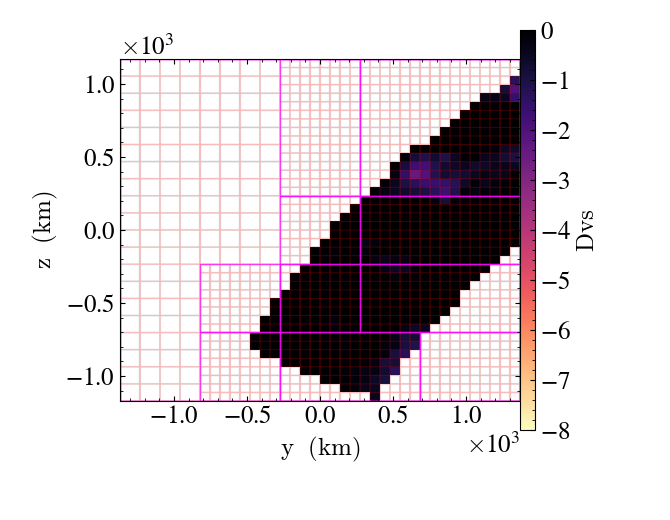

yt : [INFO     ] 2024-03-12 12:29:24,469 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 12:29:24,469 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 12:29:24,472 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-12 12:29:24,472 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-12 12:29:24,474 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



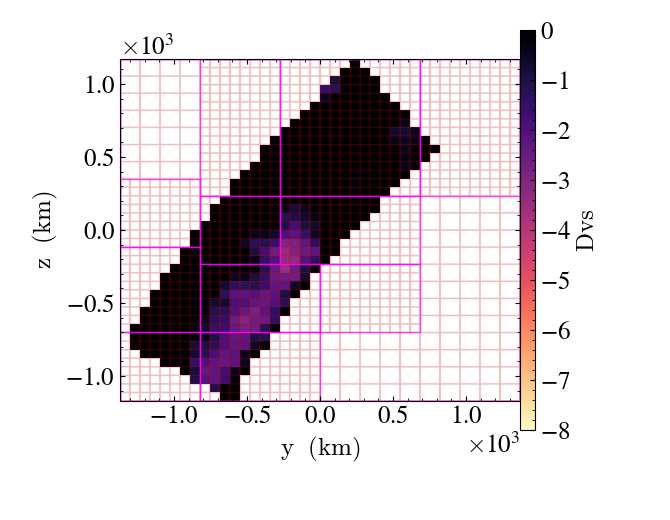

In [13]:
c = ds_yt.domain_center.copy()
c[0] = -3000.
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4), center=c)
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

c[0] = -800.
slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4), center=c)
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

In [7]:
ds_yt.domain_center

In [12]:
ds_yt.domain_right_edge